In [1]:
! pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add,AveragePooling2D,Lambda,
                                     UpSampling2D, Conv2D, MaxPool2D, Dense,Activation,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

## Data Download

In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/celeba_hq_256/25000.jpg  
  inflating: /content/dataset/celeba_hq_256/25001.jpg  
  inflating: /content/dataset/celeba_hq_256/25002.jpg  
  inflating: /content/dataset/celeba_hq_256/25003.jpg  
  inflating: /content/dataset/celeba_hq_256/25004.jpg  
  inflating: /content/dataset/celeba_hq_256/25005.jpg  
  inflating: /content/dataset/celeba_hq_256/25006.jpg  
  inflating: /content/dataset/celeba_hq_256/25007.jpg  
  inflating: /content/dataset/celeba_hq_256/25008.jpg  
  inflating: /content/dataset/celeba_hq_256/25009.jpg  
  inflating: /content/dataset/celeba_hq_256/25010.jpg  
  inflating: /content/dataset/celeba_hq_256/25011.jpg  
  inflating: /content/dataset/celeba_hq_256/25012.jpg  
  inflating: /content/dataset/celeba_hq_256/25013.jpg  
  inflating: /content/dataset/celeba_hq_256/25014.jpg  
  inflating: /content/dataset/celeba_hq_256/25015.jpg  
  inflating: /content/dataset/celeba_hq_256/25016.jpg

## Data Preparation

In [ ]:
NOISE_DIM = 512
BATCH_SIZE = [16, 16, 16, 16, 16, 16,]
EPOCHS = 50

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
def create_dataset(res,BATCH_SIZE):
  ds_train = tf.keras.preprocessing.image_dataset_from_directory(
      "/content/dataset/celeba_hq_256", label_mode=None, image_size=(res,res), batch_size=BATCH_SIZE)

  train_dataset = (
      ds_train
      .map(preprocess)
      .unbatch()
      .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
      .batch(BATCH_SIZE,drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
  )
  return train_dataset
train_dataset = create_dataset(4,BATCH_SIZE[0])

Found 30000 files belonging to 1 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(16, 4, 4, 3), dtype=tf.float32, name=None)>

In [ ]:
for d in create_dataset(256,32).take(1):
  print(d.shape)

Found 30000 files belonging to 1 classes.
(32, 256, 256, 3)


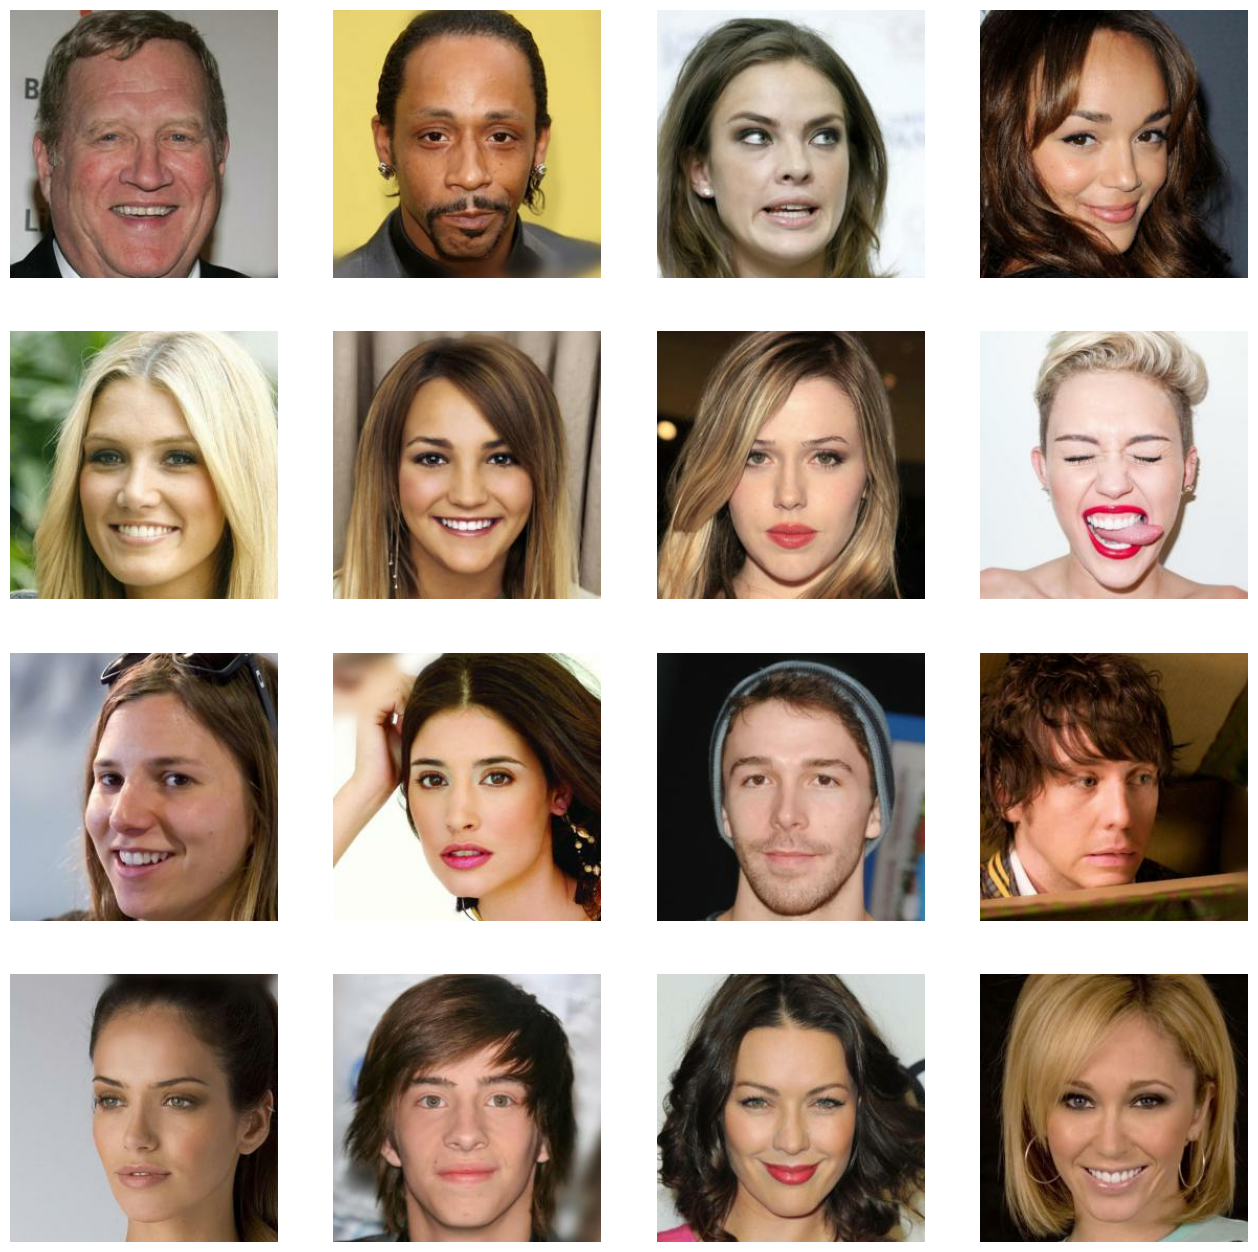

In [ ]:
plt.figure(figsize = (16,16))
k=0
n = 16
for i in range(n):
    ax = plt.subplot(4,4, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

# Modeling

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PixelNormalization(Layer):
  def __init__(self,):
    super(PixelNormalization, self).__init__()
  def call(self, inputs):
    mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
    l2 = tf.math.rsqrt(mean_square + 1.0e-8)
    normalized = inputs * l2
    return normalized

In [ ]:
@tf.keras.utils.register_keras_serializable()
class WeightScaling(Layer):
    def __init__(self, shape, gain = np.sqrt(2),):
      super(WeightScaling, self).__init__()
      #shape = tf.constant(shape, dtype=tf.float32)
      fan_in = tf.math.reduce_prod(shape)
      self.wscale = gain*tf.math.rsqrt(fan_in)

    def call(self, inputs):
      inputs = tf.cast(inputs, tf.float32)
      return inputs * self.wscale

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Bias(Layer):
    def __init__(self, ):
        super(Bias, self).__init__()

    def build(self, input_shape):
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(
            initial_value = b_init(shape=(input_shape[-1],), dtype='float32'),
            trainable=True)

    def call(self, inputs,):
        return inputs + self.bias

In [ ]:
@tf.keras.utils.register_keras_serializable()
class WeightScalingDense(Layer):
    def __init__(self, n_units,gain,use_pixelnorm=False,activate=None):
      super(WeightScalingDense, self).__init__()
      self.n_units=n_units
      self.gain=gain
      self.use_pixelnorm=use_pixelnorm
      self.activate=activate
    def build(self,input_shape):

      self.dense=Dense(
          self.n_units,
          use_bias=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
          dtype='float32')
      self.bias=Bias()


    def call(self,inputs):
      in_filters = tf.shape(inputs)[-1]

      x=self.dense(inputs)

      x=WeightScaling(shape=(tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
      x=self.bias(x)

      if self.activate=='LeakyReLU':
          x=LeakyReLU(0.2)(x)
      elif self.activate=='tanh':
          x=Activation('tanh')(x)

      if self.use_pixelnorm:
          x=PixelNormalization()(x)
      return x

    def get_config(self):
      config = super(WeightScalingDense, self).get_config()
      config.update({
          'n_units': self.n_units,
          'gain': self.gain,
          'use_pixelnorm': self.use_pixelnorm,
          'activation': self.activate
      })
      return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class WeightScalingConv(Layer):
    def __init__(self, n_filters,kernel_size,gain,use_pixelnorm=False,activate=None, strides=(1,1)):
      super(WeightScalingConv, self).__init__()
      self.n_filters=n_filters
      self.gain=gain
      self.kernel_size=kernel_size
      self.use_pixelnorm=use_pixelnorm
      self.activate=activate
      self.strides=strides
    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,
          self.kernel_size,
          strides=self.strides,
          use_bias=False,
          padding="same",
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
          dtype='float32')
      self.bias=Bias()

    def call(self,inputs):
      in_filters = tf.shape(inputs)[-1]

      x=self.conv(inputs)
      x=WeightScaling(shape=(tf.cast(self.kernel_size[0],dtype=tf.float32),tf.cast(self.kernel_size[1],dtype=tf.float32),tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
      x=self.bias(x)

      if self.activate=='LeakyReLU':
          x=LeakyReLU(0.2)(x)
      elif self.activate=='tanh':
          x=Activation('tanh')(x)

      if self.use_pixelnorm:
          x = PixelNormalization()(x)
      return x

    def get_config(self):
      config = super(WeightScalingConv, self).get_config()
      config.update({
          'n_filters': self.n_filters,
          'gain': self.gain,
          'kernel_size': self.kernel_size,
          'activation': self.activate,
          'use_pixelnorm': self.use_pixelnorm,
          'strides': self.strides
      })
      return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
      super(MinibatchStdev, self).__init__(**kwargs)

    def call(self, inputs):
      mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
      stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
      average_stddev = tf.reduce_mean(stddev, keepdims=True)
      shape = tf.shape(inputs)
      minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
      combined = tf.concat([inputs, minibatch_stddev], axis=-1)

      return combined

In [ ]:
FILTERS = [512, 512, 512, 512, 256, 128, 64]

In [ ]:
@tf.keras.utils.register_keras_serializable()
class WeightedSum(Layer):
    def __init__(self,):
      super(WeightedSum, self).__init__()
    def build(self,input_shape):
      self.alpha = tf.Variable(0., dtype=tf.float32, trainable=False)
    def call(self,inputs):
      return ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))

In [ ]:
@tf.keras.utils.register_keras_serializable()
class ProGAN(Model):
    def __init__(self,latent_dim,d_steps=1,gp_weight=10.0,drift_weight=0.001,):
      super(ProGAN, self).__init__()
      self.latent_dim = latent_dim
      self.d_steps = d_steps
      self.gp_weight = gp_weight
      self.drift_weight = drift_weight
      self.n_depth = 0
      self.discriminator = self.init_discriminator()
      self.discriminator_wt_fade = None
      self.generator = self.init_generator()
      self.generator_wt_fade = None

    def init_discriminator(self):
      img_input = Input(shape = (4,4,3))
      img_input = tf.cast(img_input, tf.float32)

      # fromRGB
      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(1,1),gain=np.sqrt(2),activate='LeakyReLU')(img_input)

      x = MinibatchStdev()(x)

      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(3,3),gain=np.sqrt(2),activate='LeakyReLU')(x)
      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(4,4),gain=np.sqrt(2),activate='LeakyReLU', strides=(4,4))(x)

      x = Flatten()(x)

      x= WeightScalingDense(n_units=1,gain=1.)(x)

      d_model = Model(img_input, x, name='discriminator')

      return d_model

    def fade_in_discriminator(self):
      input_shape = list(self.discriminator.input.shape)

      input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])
      img_input = Input(shape = input_shape)
      img_input = tf.cast(img_input, tf.float32)
      ################## Left
      x1 = AveragePooling2D()(img_input)
      x1 = self.discriminator.layers[1](x1)

      x2=WeightScalingConv(FILTERS[self.n_depth],(1,1),np.sqrt(2),activate='LeakyReLU')(img_input)
      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)
      x2=WeightScalingConv(FILTERS[self.n_depth-1],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)

      x2 = AveragePooling2D()(x2)

      x = WeightedSum()([x1, x2])

      for i in range(2, len(self.discriminator.layers)):
          x2 = self.discriminator.layers[i](x2)
      self.discriminator_stabilize = Model(img_input, x2, name='discriminator')

      for i in range(2, len(self.discriminator.layers)):
          x = self.discriminator.layers[i](x)
      self.discriminator = Model(img_input, x, name='discriminator')
      self.discriminator.summary()

    def stabilize_discriminator(self):
      self.discriminator = self.discriminator_stabilize
      self.discriminator.summary()

    def init_generator(self):
      noise = Input(shape=(self.latent_dim,))
      x = PixelNormalization()(noise)
      x=WeightScalingDense(n_units=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)(x)

      x = Reshape((4, 4, FILTERS[0]))(x)

      x=WeightScalingConv(FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
      x=WeightScalingConv(FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
      x=WeightScalingConv(3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)(x)

      g_model = Model(noise, x, name='generator')
      g_model.summary()
      return g_model

    def fade_in_generator(self):
      block_end = self.generator.layers[-2].output
      block_end = UpSampling2D((2,2))(block_end)

      x1 = self.generator.layers[-1](block_end)

      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(block_end)
      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(x2)
      x2=WeightScalingConv(3,(1,1),1.,activate='tanh',use_pixelnorm=False)(x2)

      self.generator_stabilize = Model(self.generator.input, x2, name='generator')

      x = WeightedSum()([x1, x2])
      self.generator = Model(self.generator.input, x, name='generator')

      self.generator.summary()

    def stabilize_generator(self):
        self.generator = self.generator_stabilize
        self.generator.summary()

    def compile(self, d_optimizer, g_optimizer):
        super(ProGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self,batch_size,real_images,fake_images):
      epsilon=tf.random.normal([batch_size,1,1,1],0.0,1.0)
      interpolation=epsilon*real_images+(1-epsilon)*fake_images

      with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolation)
        prediction=self.discriminator(interpolation,training=True)
      grads=gp_tape.gradient(prediction,interpolation)
      l2_norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
      return tf.reduce_mean((l2_norm-1)**2)
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_logits = self.discriminator(fake_images, training=True)
            real_logits = self.discriminator(real_images, training=True)

            d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

            gp = self.gradient_penalty(batch_size, real_images, fake_images)

            drift = tf.reduce_mean(tf.square(real_logits))
            d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = -tf.reduce_mean(gen_img_logits)
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}

    def get_config(self):
      config = super(ProGAN, self).get_config()
      config.update({
          'latent_dim': self.latent_dim,
          'd_steps': self.d_steps,
          'gp_weight': self.gp_weight,
          'drift_weight': self.drift_weight,
          'n_depth': self.n_depth,
      })
      return config

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self,prefix,res,latent_dim=512,steps_per_epoch=1000,epochs=50,):
        self.latent_dim = latent_dim
        self.prefix=prefix
        self.steps_per_epoch=steps_per_epoch
        self.epochs=epochs
        self.res=res

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_{}x{}_{}_epoch_{}.png".format(self.res,self.res,self.prefix,epoch+1))
        plt.close()

    def on_batch_begin(self, batch, logs=None):
      alpha = ((self.n_epoch * self.steps_per_epoch) + batch) / float(self.steps_per_epoch * self.epochs - 1)
      for layer in self.model.generator.layers:
        if isinstance(layer, WeightedSum):
          layer.alpha.assign(alpha)
      for layer in self.model.discriminator.layers:
        if isinstance(layer, WeightedSum):
          layer.alpha.assign(alpha)

In [ ]:
!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
STEPS_PER_EPOCH=1000
EPOCHS=10
NOISE_DIM=512

In [ ]:
train_dataset = create_dataset(4,BATCH_SIZE[0])
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

pgan = ProGAN(
    latent_dim = NOISE_DIM,
    d_steps = 1,
)

pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

cbk=ShowImage('initial',4,latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])

Found 30000 files belonging to 1 classes.
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 512)]             0         
                                                                 
 pixel_normalization_31 (Pi  (None, 512)               0         
 xelNormalization)                                               
                                                                 
 weight_scaling_dense_3 (We  (None, 8192)              4202496   
 ightScalingDense)                                               
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 weight_scaling_conv_15 (We  (None, 4, 4, 512)         4194816   
 ightScalingConv)                                                
               

1000/1000 [==============================] - 63s 60ms/step - d_loss: -0.5629 - g_loss: 0.8140
Epoch 2/10
1000/1000 [==============================] - 60s 60ms/step - d_loss: -0.0774 - g_loss: 0.3308
Epoch 3/10
1000/1000 [==============================] - 60s 60ms/step - d_loss: -0.1146 - g_loss: 0.3221
Epoch 4/10
1000/1000 [==============================] - 62s 61ms/step - d_loss: -0.1546 - g_loss: 0.3870
Epoch 5/10
1000/1000 [==============================] - 60s 59ms/step - d_loss: -0.1609 - g_loss: 0.3752
Epoch 6/10
1000/1000 [==============================] - 60s 60ms/step - d_loss: -0.1419 - g_loss: 0.3506
Epoch 7/10
1000/1000 [==============================] - 61s 60ms/step - d_loss: -0.1099 - g_loss: 0.3169
Epoch 8/10
1000/1000 [==============================] - 60s 60ms/step - d_loss: -0.0878 - g_loss: 0.3172
Epoch 9/10
1000/1000 [==============================] - 61s 60ms/step - d_loss: -0.0740 - g_loss: 0.3324
Epoch 10/10
1000/1000 [==============================] - 61s 60ms/

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

for n_depth in range(1, 6):


  ################ Faded
  pgan.n_depth = n_depth
  train_dataset=create_dataset(4*(2**n_depth),BATCH_SIZE[n_depth])

  cbk=ShowImage('fading',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
  pgan.fade_in_generator()
  pgan.fade_in_discriminator()

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )

  pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])

  ################# Stabilized

  cbk=ShowImage('stabilize',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
  pgan.stabilize_generator()
  pgan.stabilize_discriminator()

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs=EPOCHS, callbacks=[cbk])

Found 30000 files belonging to 1 classes.
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 pixel_normalization_31 (Pi  (None, 512)                  0         ['input_9[0][0]']             
 xelNormalization)                                                                                
                                                                                                  
 weight_scaling_dense_3 (We  (None, 8192)                 4202496   ['pixel_normalization_31[0][0]
 ightScalingDense)                                                  ']                            
                                                

1000/1000 [==============================] - 111s 106ms/step - d_loss: -2.2162 - g_loss: 3.2359
Epoch 2/10
1000/1000 [==============================] - 106s 106ms/step - d_loss: -2.6545 - g_loss: 3.2621
Epoch 3/10
1000/1000 [==============================] - 106s 106ms/step - d_loss: -1.7703 - g_loss: 2.4293
Epoch 4/10
1000/1000 [==============================] - 107s 106ms/step - d_loss: -1.3504 - g_loss: 1.8790
Epoch 5/10
1000/1000 [==============================] - 106s 106ms/step - d_loss: -0.9272 - g_loss: 1.5122
Epoch 6/10
1000/1000 [==============================] - 107s 106ms/step - d_loss: -0.6361 - g_loss: 1.0919
Epoch 7/10
1000/1000 [==============================] - 107s 106ms/step - d_loss: -0.3767 - g_loss: 0.6610
Epoch 8/10
1000/1000 [==============================] - 107s 106ms/step - d_loss: -0.1715 - g_loss: 0.3016
Epoch 9/10
1000/1000 [==============================] - 107s 106ms/step - d_loss: -0.1552 - g_loss: 0.3132
Epoch 10/10
1000/1000 [=========================

1000/1000 [==============================] - 108s 105ms/step - d_loss: -0.2181 - g_loss: 0.5362
Epoch 2/10
1000/1000 [==============================] - 105s 104ms/step - d_loss: -0.2210 - g_loss: 0.5425
Epoch 3/10
1000/1000 [==============================] - 105s 105ms/step - d_loss: -0.2060 - g_loss: 0.5058
Epoch 4/10
1000/1000 [==============================] - 105s 105ms/step - d_loss: -0.1968 - g_loss: 0.4431
Epoch 5/10
1000/1000 [==============================] - 106s 105ms/step - d_loss: -0.1930 - g_loss: 0.4100
Epoch 6/10
1000/1000 [==============================] - 105s 105ms/step - d_loss: -0.1835 - g_loss: 0.3817
Epoch 7/10
1000/1000 [==============================] - 105s 104ms/step - d_loss: -0.1882 - g_loss: 0.4151
Epoch 8/10
1000/1000 [==============================] - 105s 105ms/step - d_loss: -0.1935 - g_loss: 0.4244
Epoch 9/10
1000/1000 [==============================] - 105s 104ms/step - d_loss: -0.1834 - g_loss: 0.3673
Epoch 10/10
1000/1000 [=========================

1000/1000 [==============================] - 213s 207ms/step - d_loss: -3.1377 - g_loss: 4.6812
Epoch 2/10
1000/1000 [==============================] - 206s 205ms/step - d_loss: -3.8277 - g_loss: 5.1009
Epoch 3/10
1000/1000 [==============================] - 205s 205ms/step - d_loss: -2.6444 - g_loss: 3.8299
Epoch 4/10
1000/1000 [==============================] - 206s 206ms/step - d_loss: -1.7418 - g_loss: 2.7540
Epoch 5/10
1000/1000 [==============================] - 205s 205ms/step - d_loss: -1.2056 - g_loss: 1.8908
Epoch 6/10
1000/1000 [==============================] - 205s 205ms/step - d_loss: -0.6212 - g_loss: 1.1611
Epoch 7/10
1000/1000 [==============================] - 206s 205ms/step - d_loss: -0.3410 - g_loss: 0.7588
Epoch 8/10
1000/1000 [==============================] - 206s 206ms/step - d_loss: -0.3391 - g_loss: 0.7370
Epoch 9/10
1000/1000 [==============================] - 206s 205ms/step - d_loss: -0.3634 - g_loss: 0.6543
Epoch 10/10
1000/1000 [=========================

1000/1000 [==============================] - 208s 204ms/step - d_loss: -0.5145 - g_loss: 1.0591
Epoch 2/10
1000/1000 [==============================] - 204s 204ms/step - d_loss: -0.5086 - g_loss: 1.0586
Epoch 3/10
1000/1000 [==============================] - 204s 204ms/step - d_loss: -0.5144 - g_loss: 1.0088
Epoch 4/10
1000/1000 [==============================] - 205s 205ms/step - d_loss: -0.4896 - g_loss: 0.9085
Epoch 5/10
1000/1000 [==============================] - 205s 204ms/step - d_loss: -0.4846 - g_loss: 0.9056
Epoch 6/10
1000/1000 [==============================] - 204s 204ms/step - d_loss: -0.4990 - g_loss: 0.9098
Epoch 7/10
1000/1000 [==============================] - 204s 204ms/step - d_loss: -0.4809 - g_loss: 0.8639
Epoch 8/10
1000/1000 [==============================] - 204s 204ms/step - d_loss: -0.4953 - g_loss: 0.8618
Epoch 9/10
1000/1000 [==============================] - 206s 205ms/step - d_loss: -0.5073 - g_loss: 0.8089
Epoch 10/10
1000/1000 [=========================

1000/1000 [==============================] - 529s 519ms/step - d_loss: -3.6536 - g_loss: 6.8033
Epoch 2/10
1000/1000 [==============================] - 516s 516ms/step - d_loss: -4.0853 - g_loss: 6.7854
Epoch 3/10
  55/1000 [>.............................] - ETA: 8:27 - d_loss: -3.4372 - g_loss: 5.7986

KeyboardInterrupt: ignored

# Image Embeddings Model

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = VGG16(weights='imagenet', input_shape=(128, 128, 3), include_top=False)

input_layer = Input(shape=(128, 128, 3))
preprocess_layer = preprocess_input(input_layer)
x = base_model(preprocess_layer, training=False)
x = GlobalAveragePooling2D()(x)
output_layer = Dense(512, activation='relu')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                      

In [38]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Facial_Encoding_Model.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [47]:
model_path = "/content/drive/MyDrive/Pro_GAN_Model/Facial_Encoding_Model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = "/content/dataset/celeba_hq_256/00000.jpg"
image = tf.io.decode_png(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [128, 128]), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [49]:
output_data.shape

(1, 512)

# Saving and Loading Model

In [ ]:
pgan.generator.save("PROGAN")
loaded_model = tf.keras.models.load_model("PROGAN")

1/1 [==============================] - 0s 30ms/step


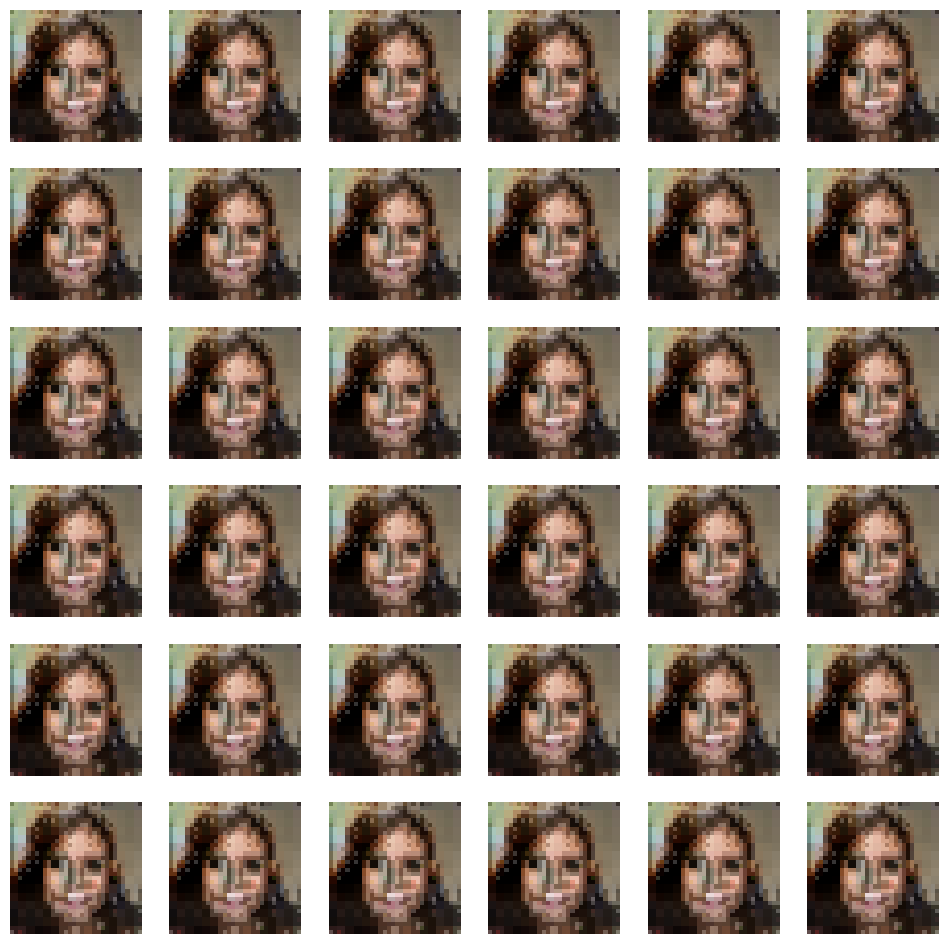

In [45]:
image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SIZE = 128
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
encoding = model.predict(image)

n = 6
k = 0
latent_dim = 512
plt.figure(figsize=(12, 12))
for i in range(n):
  for j in range(n):
    ax = plt.subplot(n, n, k+1)
    output = loaded_model(encoding)
    plt.imshow((output[0]+1)/2,)
    plt.axis('off')
    k+=1
plt.savefig("Generated_Images")

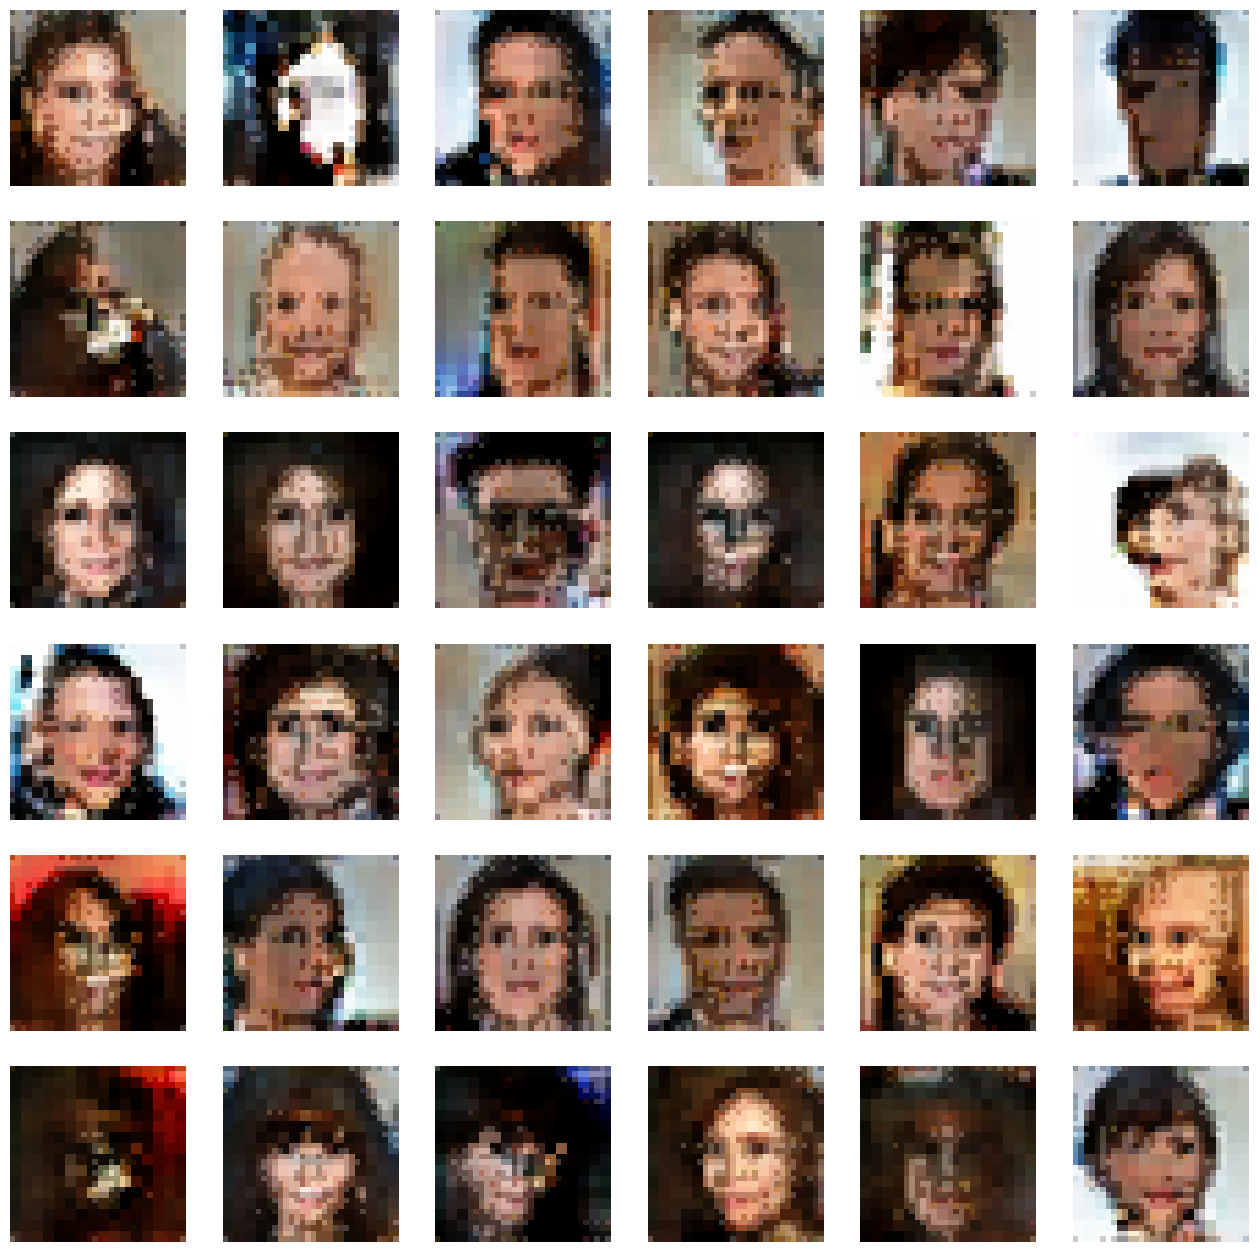

In [8]:
n = 6
k = 0
latent_dim = 512
output = loaded_model(tf.random.normal(shape=(36, latent_dim)))
plt.figure(figsize=(16, 16))
for i in range(n):
  for j in range(n):
    ax = plt.subplot(n, n, k+1)
    plt.imshow((output[k]+1)/2,)
    plt.axis('off')
    k+=1
plt.savefig("Generated_Images")

# Hugging Face

In [4]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.8 MB/s eta 0:00:00


In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = pgan.generator, repo_id = "DriveMyScream/Pro_GAN_Image_Generator")

keras_metadata.pb:   0%|          | 0.00/46.9k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/395k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Pro_GAN_Image_Generator/tree/main/'

In [6]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Pro_GAN_Image_Generator")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 207ms/step


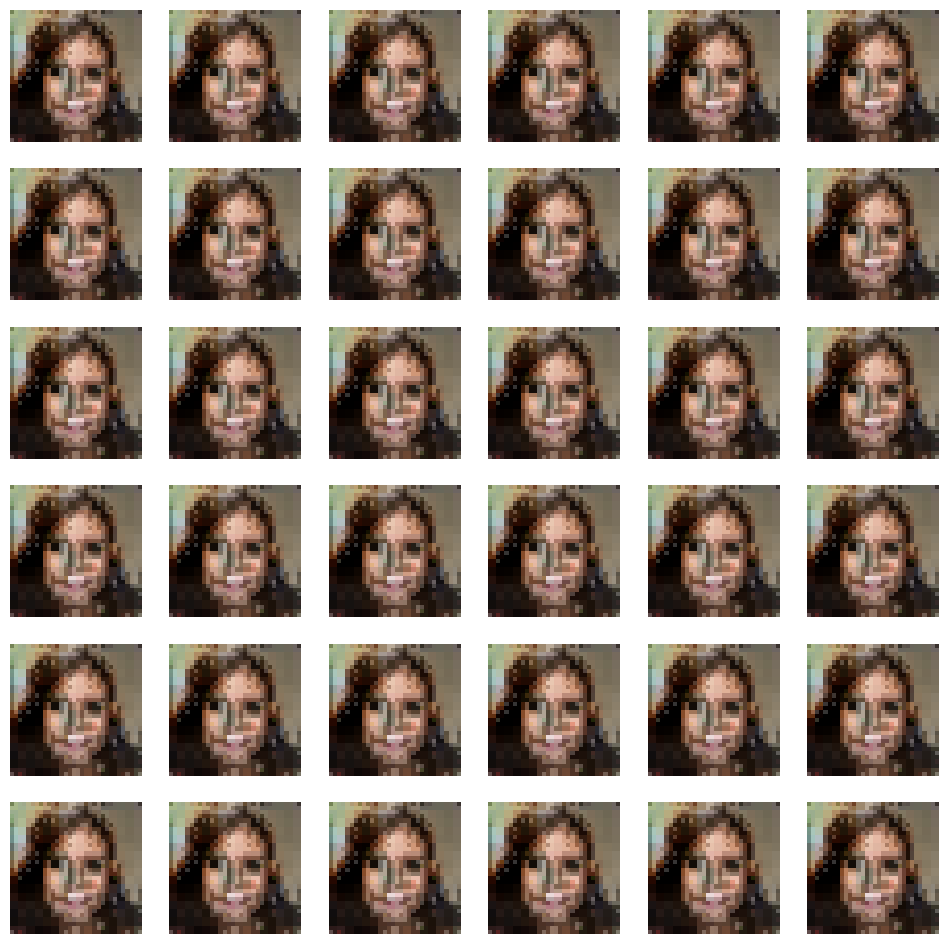

In [42]:
image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SIZE = 128
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
encoding = model.predict(image)

n = 6
k = 0
latent_dim = 512
plt.figure(figsize=(12, 12))
for i in range(n):
  for j in range(n):
    ax = plt.subplot(n, n, k+1)
    output = loaded_model(encoding)
    plt.imshow((output[0]+1)/2,)
    plt.axis('off')
    k+=1
plt.savefig("Generated_Images")

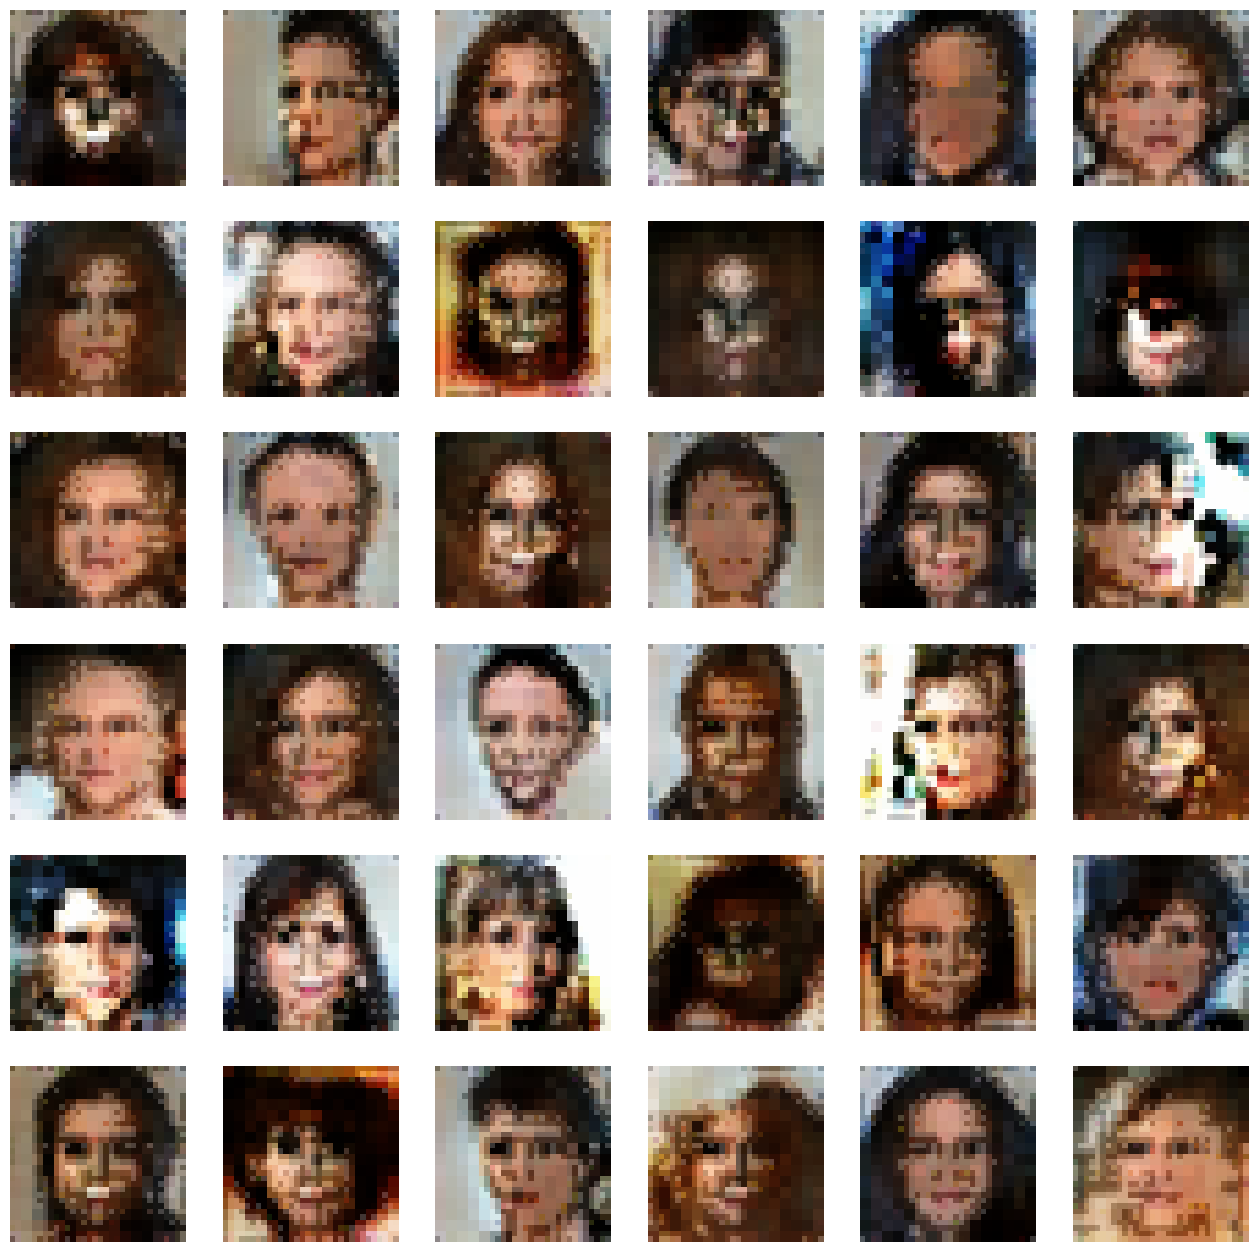

In [7]:
n = 6
k = 0
latent_dim = 512
output = loaded_model(tf.random.normal(shape=(36, latent_dim)))
plt.figure(figsize=(16, 16))
for i in range(n):
  for j in range(n):
    ax = plt.subplot(n, n, k+1)
    plt.imshow((output[k]+1)/2,)
    plt.axis('off')
    k+=1
plt.savefig("Generated_Images")

# Tensorflow Lite

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pgan.generator)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Pro_GAN_Image_Generator.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

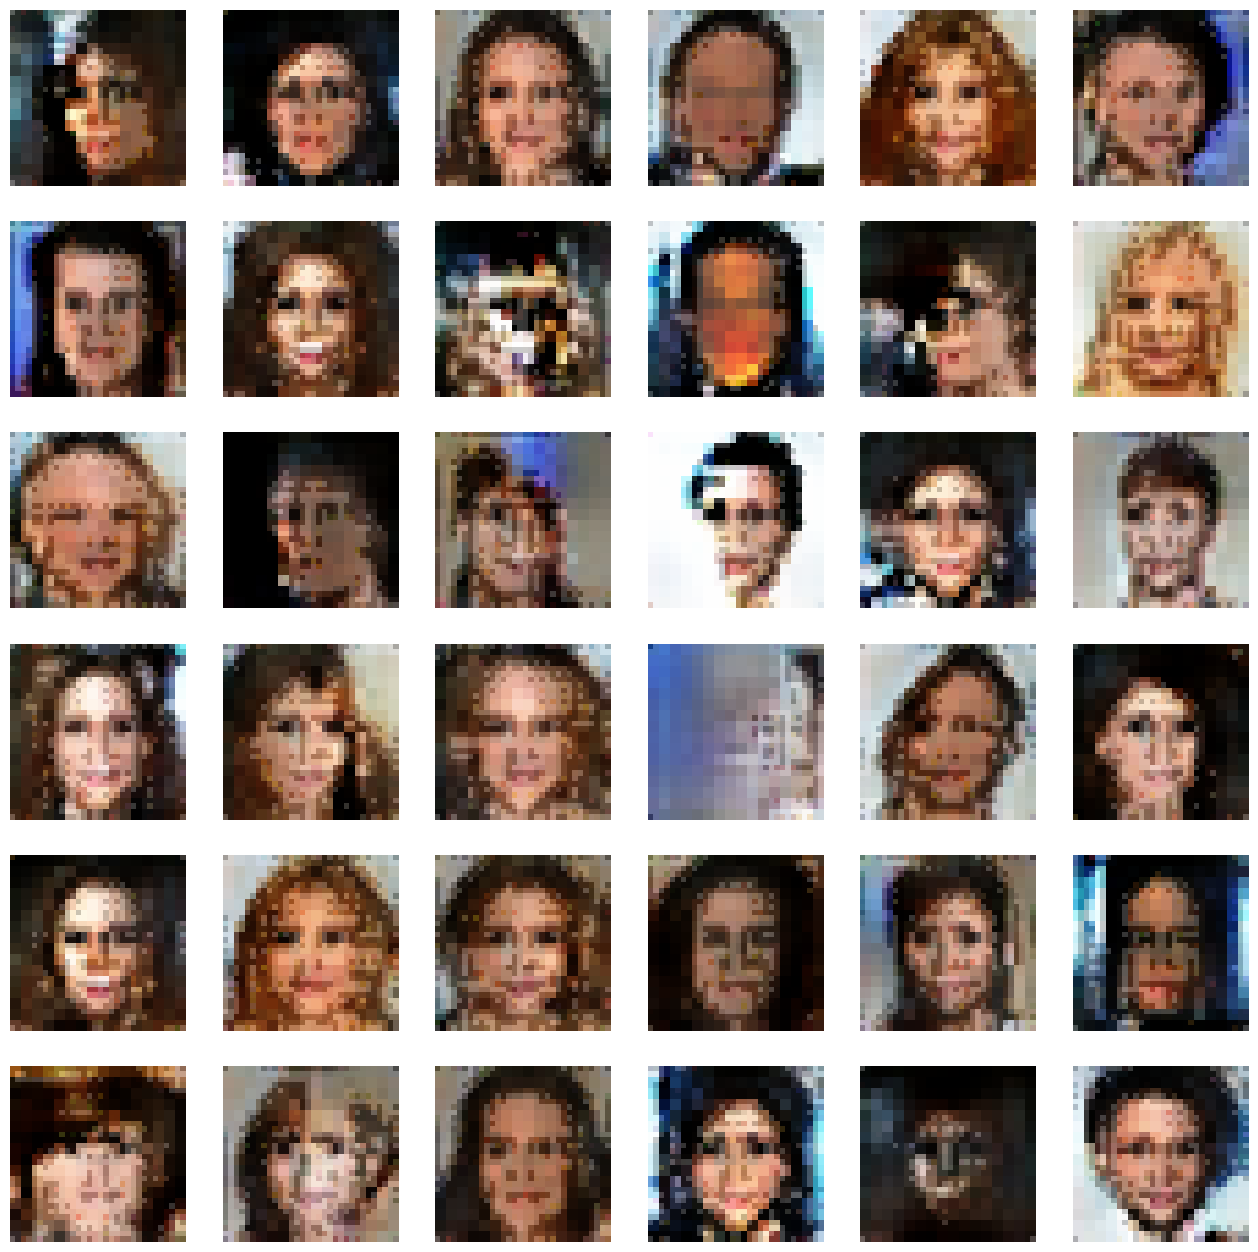

In [37]:
tflite_model_path = "/content/drive/MyDrive/Pro_GAN_Image_Generator.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

n = 6
k = 0
latent_dim = 512

random_inputs = tf.random.normal(shape=(n * n, latent_dim), dtype=tf.float32)
generated_images = []
for i in range(n * n):
    interpreter.set_tensor(input_details[0]['index'], random_inputs[i:i+1])
    interpreter.invoke()
    output_image = interpreter.get_tensor(output_details[0]['index'])
    output_image = (output_image + 1) / 2
    generated_images.append(output_image[0])

plt.figure(figsize=(16, 16))
for i in range(n):
    for j in range(n):
        ax = plt.subplot(n, n, k+1)
        plt.imshow(generated_images[k])
        plt.axis('off')
        k += 1
plt.savefig("Generated_Images")
plt.show()

1/1 [==============================] - 0s 31ms/step


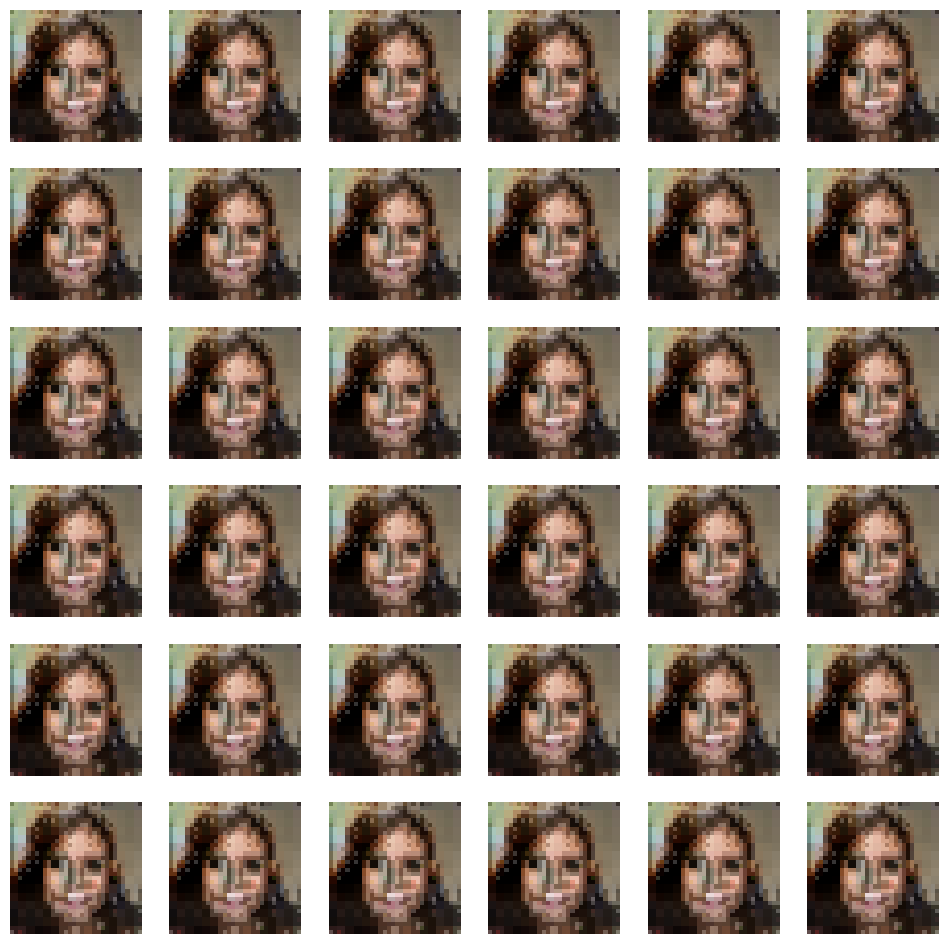

In [46]:
tflite_model_path = "/content/drive/MyDrive/Pro_GAN_Model/Pro_GAN_Image_Generator.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

n = 6
k = 0
latent_dim = 512

image_path = "/content/dataset/celeba_hq_256/00000.jpg"
IMG_SIZE = 128
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
encoding = model.predict(image)

generated_images = []
for i in range(n * n):
    interpreter.set_tensor(input_details[0]['index'], encoding)
    interpreter.invoke()
    output_image = interpreter.get_tensor(output_details[0]['index'])
    output_image = (output_image + 1) / 2
    generated_images.append(output_image[0])

plt.figure(figsize=(12, 12))
for i in range(n):
    for j in range(n):
        ax = plt.subplot(n, n, k+1)
        plt.imshow(generated_images[k])
        plt.axis('off')
        k += 1
plt.savefig("Generated_Images")
plt.show()